In [1]:
import pandas as pd
import numpy as np
import re
import sklearn

In [2]:
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="dark") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)

plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [3]:
# Define function to extract titles from passenger names
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

In [4]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

passengerId = test['PassengerId']
survived = train['Survived']

full_data = [train, test]

In [5]:
# Create a new feature Title, containing the titles of passenger names
for dataset in full_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
    # Group all non-common titles into one single grouping "Rare"
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col'
                     'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    
for dataset in full_data:

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    
    # Mapping titles
    title_mapping = {}
    for i,title in enumerate(dataset['Title'].unique()):
        title_mapping[title] = i
    
    dataset['Title'] = dataset['Title'].map(title_mapping)
    
    
    

In [6]:
# Create new feature FamilySize as a combination of SibSp and Parch
for dataset in full_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1
    
    # Create new feature IsAlone from FamilySize
    dataset['IsAlone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'IsAlone'] = 1
    
    # Remove all NULLS in the Embarked column
    dataset['Embarked'] = dataset['Embarked'].fillna('S')
    
    # Remove all NULLS in the Fare column
    dataset['Fare'] = dataset['Fare'].fillna(train['Fare'].median())
    
    # Remove all NULLS in the Fare column
    dataset['Age'] = dataset['Age'].fillna(train['Age'].median())
    
    # Mapping Sex
    dataset['Sex'] = dataset['Sex'].map( {'female': 0, 'male': 1} ).astype(int)
     
    # Mapping Embarked
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)
    
    
   

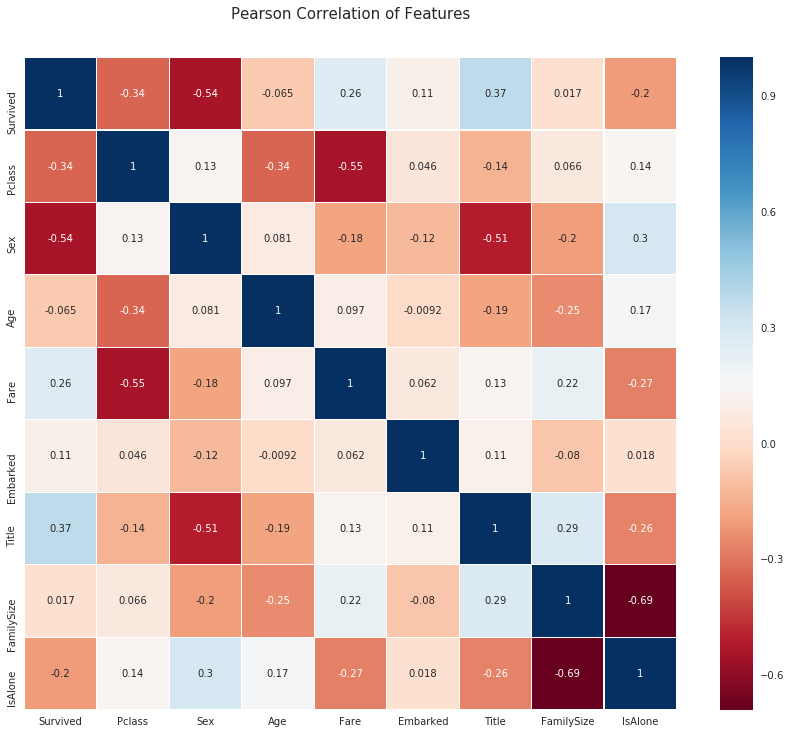

In [7]:
drop_elements = ['PassengerId', 'Name', 'Ticket','SibSp','Parch','Cabin']
train.drop(drop_elements,axis=1,inplace=True)
test.drop(drop_elements,axis=1,inplace=True)

colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(train.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

In [8]:
#Create dummies for Embarked and Pclass
train = pd.get_dummies(train,columns=['Embarked'])
test = pd.get_dummies(test,columns=['Embarked'])

In [9]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Prepare data for training

# Data to numpy
X = train.iloc[:,1:].values
y = train.iloc[:,0].values


# Scale the data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
test = scaler.transform(test)


skf = StratifiedKFold(n_splits=4,shuffle=True)

# Classifiers we will use
classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               SVC()]
clfs = {}
acc = {}

for clf in classifiers:
    clfs[clf.__class__.__name__] = clf
    acc[clf.__class__.__name__] = []
    

In [10]:
# Train every classifier
for train_index,test_index in skf.split(X,y):
    
    X_train,X_test = X[train_index],X[test_index]
    y_train,y_test = y[train_index],y[test_index]

    
    for key,value in clfs.items():
        value.fit(X_train,y_train)
        acc[key].append(value.score(X_test,y_test))


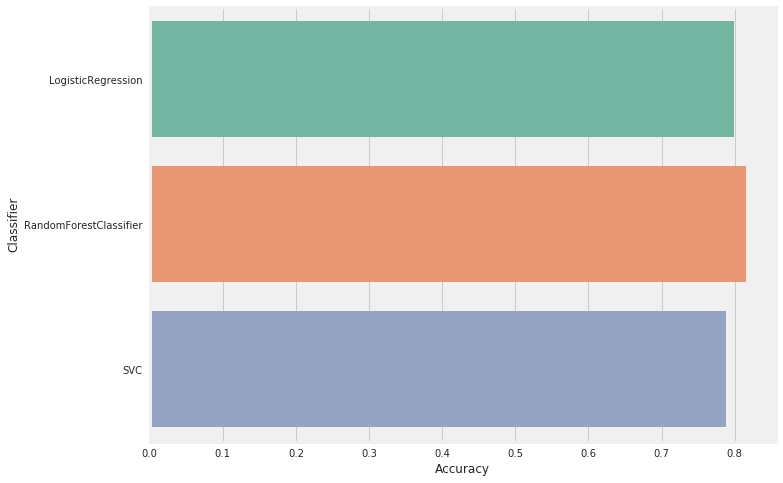

In [11]:
# Get mean score of all classifiers
mean_score = {k:sum(v)/len(v) for k,v in acc.items()}

#Store results in log
log = pd.DataFrame(list(mean_score.items()),columns=['Accuracy','Classifier'])

log.sort_values(by='Accuracy')
# Plot results
plt.figure(figsize=(10,8))

sns.barplot(x='Classifier', y='Accuracy', data=log, palette='Set2')

plt.xlabel('Accuracy')
plt.ylabel('Classifier')
plt.show()

In [12]:
# Use best classifier for final prediction
best = clfs[max(mean_score,key=mean_score.get)]

best.fit(X,y)
predictions = best.predict(test)


In [13]:
# Generate Submission File 

StackingSubmission = pd.DataFrame({'PassengerId': passengerId,
                            'Survived': predictions })
StackingSubmission.to_csv("StackingSubmission.csv", index=False)